In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report,
    confusion_matrix, average_precision_score, precision_recall_curve
)

sns.set_style("whitegrid")

BASE_DIR = r"D:\ML_Project"
MODELS_DIR = os.path.join(BASE_DIR, "models")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

os.makedirs(RESULTS_DIR, exist_ok=True)

print("GRID SEARCH PIPELINE → READY")


GRID SEARCH PIPELINE → READY


In [2]:
# Load balanced data
X_train = joblib.load(os.path.join(MODELS_DIR, "X_train_bal.joblib"))
y_train = joblib.load(os.path.join(MODELS_DIR, "y_train_bal.joblib"))

# Load real test set
X_test = joblib.load(os.path.join(MODELS_DIR, "X_test.joblib"))
y_test = joblib.load(os.path.join(MODELS_DIR, "y_test.joblib"))

# Label encoder for decoding predictions
le = joblib.load(os.path.join(MODELS_DIR, "label_encoder.joblib"))

print("Train:", X_train.shape, " | Test:", X_test.shape)

n_classes = len(le.classes_)


Train: (431691, 20)  | Test: (49810, 20)


In [3]:
top5_names = joblib.load(os.path.join(MODELS_DIR, "top5_model_names.joblib"))
untuned_models = joblib.load(os.path.join(MODELS_DIR, "top5_untuned_models.joblib"))

print("Top 4 models selected for tuning:")
print(top5_names)


Top 4 models selected for tuning:
['Random Forest', 'XGBoost', 'LightGBM', 'Decision Tree', 'Logistic Regression']


In [4]:
param_grids = {
    "Logistic Regression": {
        "C": [0.5, 1, 2, 5],
        "solver": ["lbfgs"],
        "class_weight": ["balanced"],
        "max_iter": [4000]
    },

    "Decision Tree": {
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2]
    },

    "Random Forest": {
        "n_estimators": [200, 300],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5],
        "class_weight": ["balanced"]
    },

    "XGBoost": {
        "n_estimators": [300, 500],
        "max_depth": [4, 6, 8],
        "learning_rate": [0.05, 0.1],
        "subsample": [0.8, 1.0],
    },

    "LightGBM": {
        "n_estimators": [300, 500],
        "learning_rate": [0.05, 0.1],
        "num_leaves": [31, 63],
        "subsample": [0.8, 1.0],
    }
}


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=4000),

    "Decision Tree": DecisionTreeClassifier(),

    "Random Forest": RandomForestClassifier(),

    "XGBoost": XGBClassifier(
        objective="multi:softprob",
        num_class=n_classes,
        device="cuda",
        tree_method="hist",
        eval_metric="mlogloss"
    ),

    "LightGBM": LGBMClassifier(
        objective="multiclass",
        num_class=n_classes,
        device="gpu"
    ),
}

# Only keep top 4
models = {name: models[name] for name in top5_names}


In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
best_scores = {}
grid_times = {}

for name in models:
    print("\n" + "="*80)
    print(f"GRID SEARCH → {name}")

    model = models[name]
    params = param_grids[name]

    gs = GridSearchCV(
        model,
        params,
        scoring="f1_macro",
        cv=cv,
        n_jobs=6,
        verbose=1,
        refit=True
    )

    t0 = time.time()
    gs.fit(X_train, y_train)
    t1 = time.time()

    best_models[name] = gs.best_estimator_
    best_scores[name] = gs.best_score_
    grid_times[name] = t1 - t0

    print(f"\nBest F1 (CV): {gs.best_score_:.4f}")
    print("Best Params:", gs.best_params_)
    print(f"Time: {grid_times[name]/60:.2f} mins")

    joblib.dump(gs.best_estimator_, os.path.join(MODELS_DIR, f"best_tuned_{name}.joblib"))



GRID SEARCH → Random Forest
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best F1 (CV): 0.9512
Best Params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Time: 6.79 mins

GRID SEARCH → XGBoost
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best F1 (CV): 0.9487
Best Params: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500, 'subsample': 0.8}
Time: 6.51 mins

GRID SEARCH → LightGBM
Fitting 5 folds for each of 16 candidates, totalling 80 fits


d:\ML_Project\ml_env\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1059
[LightGBM] [Info] Number of data points in the train set: 431691, number of used features: 20
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 5070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (3.29 MB) transferred to GPU in 0.003776 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612

Best F1 (CV): 0.9525
Best Params: {'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 63, 'subsample': 0.8}
Time: 39.99 mins

GRID SEARCH → Decision Tree
Fitting 5 folds for each of 18 candidates, totalling 90 


--------------------------------------------------------------------------------
Evaluating: Random Forest
Test F1: 0.8070 | Acc: 0.8893 | PR-AUC: 0.8129
                         precision    recall  f1-score   support

       Critical_Failure       0.97      0.89      0.93     42323
Hospitalization_Failure       0.91      0.98      0.94      3532
     SideEffect_Failure       0.42      0.77      0.55      3955

               accuracy                           0.89     49810
              macro avg       0.77      0.88      0.81     49810
           weighted avg       0.93      0.89      0.90     49810



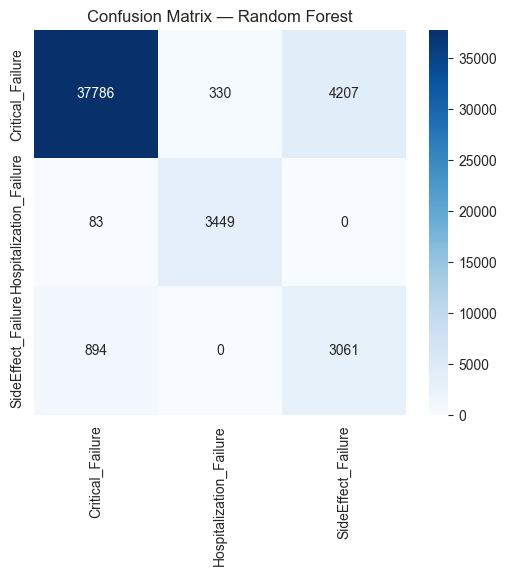


--------------------------------------------------------------------------------
Evaluating: XGBoost
Test F1: 0.8101 | Acc: 0.8828 | PR-AUC: 0.8379

d:\ML_Project\ml_env\Lib\site-packages\xgboost\core.py:774: UserWarning: [18:03:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



                         precision    recall  f1-score   support

       Critical_Failure       0.98      0.88      0.93     42323
Hospitalization_Failure       0.92      0.98      0.95      3532
     SideEffect_Failure       0.41      0.86      0.55      3955

               accuracy                           0.88     49810
              macro avg       0.77      0.91      0.81     49810
           weighted avg       0.93      0.88      0.90     49810



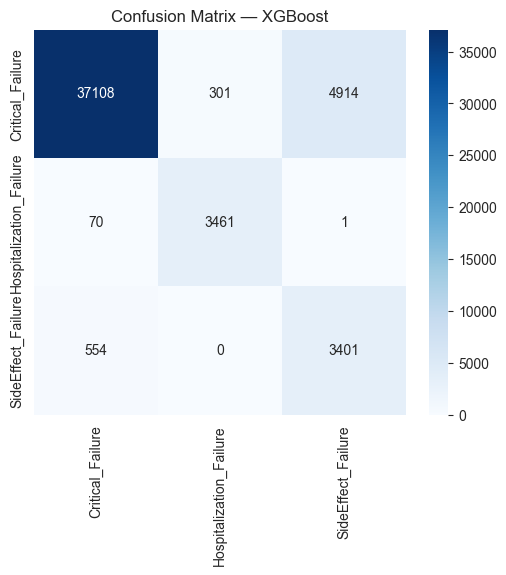


--------------------------------------------------------------------------------
Evaluating: LightGBM
Test F1: 0.8105 | Acc: 0.8873 | PR-AUC: 0.8365
                         precision    recall  f1-score   support

       Critical_Failure       0.98      0.89      0.93     42323
Hospitalization_Failure       0.91      0.98      0.94      3532
     SideEffect_Failure       0.42      0.83      0.56      3955

               accuracy                           0.89     49810
              macro avg       0.77      0.90      0.81     49810
           weighted avg       0.93      0.89      0.90     49810



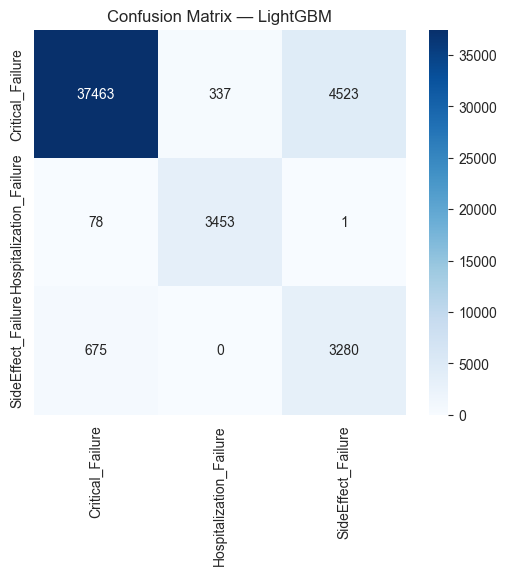


--------------------------------------------------------------------------------
Evaluating: Decision Tree
Test F1: 0.8037 | Acc: 0.8891 | PR-AUC: 0.7622
                         precision    recall  f1-score   support

       Critical_Failure       0.97      0.90      0.93     42323
Hospitalization_Failure       0.92      0.96      0.94      3532
     SideEffect_Failure       0.42      0.75      0.54      3955

               accuracy                           0.89     49810
              macro avg       0.77      0.87      0.80     49810
           weighted avg       0.92      0.89      0.90     49810



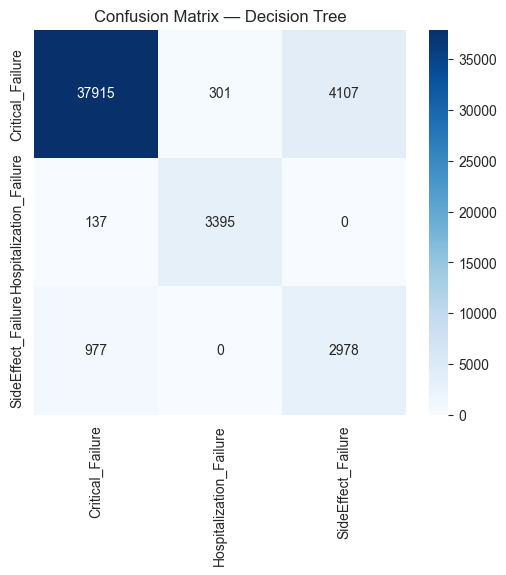


--------------------------------------------------------------------------------
Evaluating: Logistic Regression
Test F1: 0.7684 | Acc: 0.8225 | PR-AUC: 0.8059
                         precision    recall  f1-score   support

       Critical_Failure       0.99      0.80      0.88     42323
Hospitalization_Failure       0.92      0.98      0.95      3532
     SideEffect_Failure       0.31      0.96      0.47      3955

               accuracy                           0.82     49810
              macro avg       0.74      0.91      0.77     49810
           weighted avg       0.93      0.82      0.86     49810



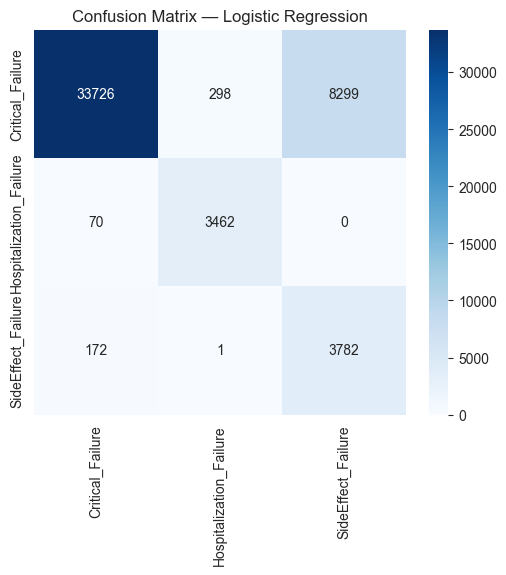

,Model,F1,Accuracy,PR-AUC
0,Random Forest,0.806998,0.889299,0.812878
1,XGBoost,0.810126,0.882754,0.837933
2,LightGBM,0.810454,0.887292,0.836481
3,Decision Tree,0.803672,0.889139,0.762247
4,Logistic Regression,0.768411,0.822526,0.805856


In [7]:
eval_rows = []

for name, model in best_models.items():
    print("\n" + "-"*80)
    print(f"Evaluating: {name}")

    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)
    except:
        y_proba = model.decision_function(X_test)

    f1 = f1_score(y_test, y_pred, average="macro")
    acc = accuracy_score(y_test, y_pred)
    pr_auc = average_precision_score(y_test, y_proba, average="macro")

    eval_rows.append([name, f1, acc, pr_auc])

    print(f"Test F1: {f1:.4f} | Acc: {acc:.4f} | PR-AUC: {pr_auc:.4f}")

    # Report
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix — {name}")
    plt.show()

eval_df = pd.DataFrame(eval_rows, columns=["Model", "F1", "Accuracy", "PR-AUC"])
display(eval_df)

eval_df.to_csv(os.path.join(RESULTS_DIR, "tuned_model_scores.csv"), index=False)


In [8]:
best_name = eval_df.sort_values("F1", ascending=False).iloc[0]["Model"]
print("\nBest final model:", best_name)

final_model = best_models[best_name]

joblib.dump(final_model, os.path.join(MODELS_DIR, "best_classifier_final.joblib"))
print("Saved final best model → best_classifier_final.joblib")



Best final model: LightGBM
Saved final best model → best_classifier_final.joblib
